In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d warcoder/tyre-quality-classification

tyre-quality-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tyre-quality-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  array_to_img,
                                                  img_to_array,
                                                  load_img)
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout

In [68]:
# prapare Data With Data Augementation

train_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)


train_data = train_gen.flow_from_directory(
    "/content/Digital images of defective and good condition tyres",
    target_size = (200,200),
    batch_size = 24,
    class_mode = 'categorical'
)

Found 1856 images belonging to 2 classes.


In [7]:
# now prepare the mobile net model
conv_base = MobileNetV2(
    input_shape = (200,200,3),
    include_top = False,
    weights="imagenet",
    pooling="max",
)

In [8]:
# now check with all layers
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 True
Conv1 True
bn_Conv1 True
Conv1_relu True
expanded_conv_depthwise True
expanded_conv_depthwise_BN True
expanded_conv_depthwise_relu True
expanded_conv_project True
expanded_conv_project_BN True
block_1_expand True
block_1_expand_BN True
block_1_expand_relu True
block_1_pad True
block_1_depthwise True
block_1_depthwise_BN True
block_1_depthwise_relu True
block_1_project True
block_1_project_BN True
block_2_expand True
block_2_expand_BN True
block_2_expand_relu True
block_2_depthwise True
block_2_depthwise_BN True
block_2_depthwise_relu True
block_2_project True
block_2_project_BN True
block_2_add True
block_3_expand True
block_3_expand_BN True
block_3_expand_relu True
block_3_pad True
block_3_depthwise True
block_3_depthwise_BN True
block_3_depthwise_relu True
block_3_project True
block_3_project_BN True
block_4_expand True
block_4_expand_BN True
block_4_expand_relu True
block_4_depthwise True
block_4_depthwise_BN True
block_4_depthwise_relu True
block_4_project True
block_4

In [9]:
# now train from block_8_expand layer to end layer on our new data
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == "block_8_expand":
    set_trainable = True

  if set_trainable:
    layer.trainable = True

  else:
    layer.trainable = False

# now check with all layers
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [10]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 100, 100, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 100, 100, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 100, 100, 32)         0         ['bn_Conv1[

In [11]:
# Now Add Convo_base in FC layer
model = Sequential()

model.add(conv_base) # add mobilenetV_2

model.add(Flatten()) #Flatten  layer convert in 1d array

model.add(Dense(350,activation='elu',kernel_initializer="he_normal"))  # Dense layer 1
model.add(BatchNormalization())

model.add(Dense(250,activation='selu',kernel_initializer="he_normal"))  # Dense layer 2
model.add(BatchNormalization())

model.add(Dense(150,activation='selu',kernel_initializer="he_normal"))  # Dense layer 3
model.add(BatchNormalization())

model.add(Dense(2,activation='softmax'))  # output layer

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 350)               448350    
                                                                 
 batch_normalization (Batch  (None, 350)               1400      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 250)               87750     
                                                                 
 batch_normalization_1 (Bat  (None, 250)               1

In [65]:
# introduce early stoping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

In [69]:
# Now compile model
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"]
)

In [70]:
history = model.fit(
    train_data,epochs=5,
    callbacks=[early_stopping],
    steps_per_epoch=len(train_data)
)

Epoch 1/5
78/78 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9617

78/78 [==============================] - 122s 1s/step - loss: 0.1123 - accuracy: 0.9617
Epoch 2/5
78/78 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9607

78/78 [==============================] - 94s 1s/step - loss: 0.1036 - accuracy: 0.9607
Epoch 3/5
78/78 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9558

78/78 [==============================] - 93s 1s/step - loss: 0.1066 - accuracy: 0.9558
Epoch 4/5
78/78 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9709

78/78 [==============================] - 93s 1s/step - loss: 0.0987 - accuracy: 0.9709
Epoch 5/5
78/78 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9768

78/78 [==============================] - 91s 1s/step - loss: 0.0703 - accuracy: 0.9768


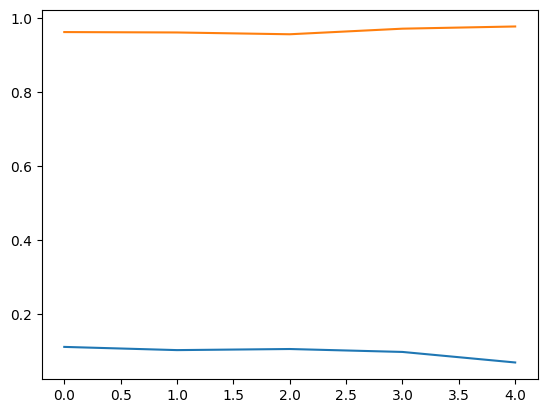

In [71]:
# plot and see the accuracy and loss
plt.plot(history.history["loss"])
plt.plot(history.history["accuracy"])

In [80]:
t = cv2.imread("/content/badtyer3.jpg")

In [81]:
t.shape

(433, 792, 3)

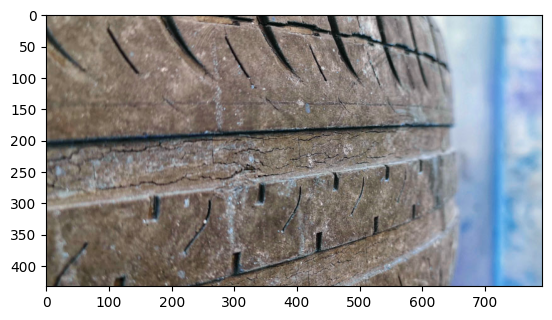

In [82]:
plt.imshow(t)

In [83]:
test_image = cv2.resize(t,(200,200))

In [84]:
test_input = test_image.reshape((1,200,200,3))

In [85]:
pred = model.predict(test_input)

1/1 [==============================] - 0s 24ms/step


In [86]:
result = np.argmax(pred,axis=1)

In [87]:
if result[0] == 0:
  print("Bad tyer")
else:
  print("Good Tyer")

Good Tyer
